In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd "/content/drive/MyDrive/To The Moon - From Reddit Comments to Stocks/Code/LSTMC"

In [1]:
# Imports
import pandas as pd
import numpy as np
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
import gc
from IPython.display import display

# Sci-kit Learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import MinMaxScaler

# NN
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Masking, Embedding, Conv2D, MaxPooling2D

In [2]:
# Load file
df = pd.read_csv("all_merged_sw.csv",
                 usecols=['post_id', 'date', 'sw_12_num_comments', 'sw_12_score', 'sw_12_total_awards',
                          'author_commentkarma', 'sw_12_compound_score', 'author_id', 'author_name',
                          'trustworthy', 'author_trust', "sw_12_author_trust",
                          'ticker', 'post_type', 'adjclose_20_X', 'adjclose_19_X', 'adjclose_18_X',
                          'adjclose_17_X', 'adjclose_16_X', 'adjclose_15_X', 'adjclose_14_X', 
                          'adjclose_13_X', 'adjclose_12_X', 'adjclose_11_X', 'adjclose_10_X',
                          'adjclose_9_X', 'adjclose_8_X', 'adjclose_7_X', 'adjclose_6_X',
                          'adjclose_5_X', 'adjclose_4_X', 'adjclose_3_X', 'adjclose_2_X',
                          'adjclose_1_X', 'adjclose_2_Y', 'adjclose_3_Y', 'adjclose_4_Y',
                          'adjclose_5_Y', 'adjclose_6_Y', 'adjclose_7_Y', 'adjclose_8_Y',
                          'adjclose_9_Y', 'adjclose_10_Y', 'adjclose_11_Y', 'adjclose_12_Y',
                          'adjclose_13_Y', 'adjclose_14_Y', 'adjclose_15_Y', 'adjclose_16_Y',
                          'adjclose_17_Y', 'adjclose_18_Y', 'adjclose_19_Y', 'adjclose_20_Y',
                          'adjclose_21_Y', 'y_slope'])

# Create trend column
df['trend'] = df['y_slope'].apply(lambda x : 1 if x >= 0.5 else (-1 if x <= -0.5 else 0))

# Apply trust filter
df = df[(df["author_trust"] >= 0.8) & (df["trustworthy"] == 1)]

df

,post_id,date,author_commentkarma,author_id,author_name,ticker,post_type,adjclose_20_X,adjclose_19_X,adjclose_18_X,...,adjclose_18_Y,adjclose_19_Y,adjclose_20_Y,adjclose_21_Y,sw_12_num_comments,sw_12_score,sw_12_total_awards,sw_12_compound_score,y_slope,trend
0,ed1i6xt,2019-01-01,1855.0,a36tf,gundeck925,CONE,comment,52.026543,51.579323,50.899178,...,49.223080,49.345276,50.144196,50.943123,2.000000,9.000000,0.000000,0.202300,0.068091,0
1,ed0rsq9,2019-01-01,8101.0,54sdn,turbotoast,CACC,comment,410.399994,412.209991,403.850006,...,411.890015,408.670013,414.369995,398.019989,1.000000,3.000000,0.000000,0.458800,0.130414,0
2,ed149cc,2019-01-01,234162.0,6lvmmbl,Shmokesshweed,WSBC,comment,38.873425,39.189323,38.214558,...,36.171829,37.799068,37.862701,36.917271,9.400000,9.800000,0.000000,-0.082100,0.143927,0
3,ed0rg2j,2019-01-01,744.0,2dk1wq99,nightman_123,WSBC,comment,38.873425,39.189323,38.214558,...,36.171829,37.799068,37.862701,36.917271,9.400000,9.800000,0.000000,-0.082100,0.143927,0
4,abjmvm,2019-01-01,744.0,2dk1wq99,nightman_123,WSBC,submission,38.873425,39.189323,38.214558,...,36.171829,37.799068,37.862701,36.917271,9.400000,9.800000,0.000000,-0.082100,0.143927,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
940780,ghmym1x,2020-12-31,4431.0,vh0ilgz,MerganzerMunson,ADES,comment,5.650000,6.020000,5.830000,...,5.250000,5.190000,5.070000,5.120000,4.911765,20.029412,1.117647,0.085724,-0.016173,0
940781,ghmym1x,2020-12-31,4431.0,vh0ilgz,MerganzerMunson,JAN,comment,4.270000,4.500000,4.620000,...,9.520000,12.990000,9.010000,9.400000,4.102564,20.367521,0.538462,0.241862,0.287662,0
940782,ghmynsf,2020-12-31,4431.0,vh0ilgz,MerganzerMunson,FEYE,comment,15.030000,15.360000,15.120000,...,21.360001,21.150000,21.000000,21.590000,4.005236,27.465969,0.193717,0.107613,-0.053455,0
940783,ghmiiu6,2020-12-31,22288.0,bgruy,DeadSol,WSBC,comment,28.073952,29.172199,29.535013,...,28.926668,29.550983,28.738380,29.313148,55.112248,34.933042,0.112248,0.056546,-0.097593,0


In [3]:
# Print the colum names
df.columns.values

array(['post_id', 'date', 'author_commentkarma', 'author_id',
       'author_name', 'ticker', 'post_type', 'adjclose_20_X',
       'adjclose_19_X', 'adjclose_18_X', 'adjclose_17_X', 'adjclose_16_X',
       'adjclose_15_X', 'adjclose_14_X', 'adjclose_13_X', 'adjclose_12_X',
       'adjclose_11_X', 'adjclose_10_X', 'adjclose_9_X', 'adjclose_8_X',
       'adjclose_7_X', 'adjclose_6_X', 'adjclose_5_X', 'adjclose_4_X',
       'adjclose_3_X', 'adjclose_2_X', 'adjclose_1_X', 'adjclose_2_Y',
       'adjclose_3_Y', 'adjclose_4_Y', 'adjclose_5_Y', 'adjclose_6_Y',
       'adjclose_7_Y', 'adjclose_8_Y', 'adjclose_9_Y', 'adjclose_10_Y',
       'adjclose_11_Y', 'adjclose_12_Y', 'adjclose_13_Y', 'adjclose_14_Y',
       'adjclose_15_Y', 'adjclose_16_Y', 'adjclose_17_Y', 'adjclose_18_Y',
       'adjclose_19_Y', 'adjclose_20_Y', 'adjclose_21_Y',
       'sw_12_num_comments', 'sw_12_score', 'sw_12_total_awards',
       'sw_12_compound_score', 'y_slope', 'trend'], dtype=object)

In [4]:
"""Find when to buy and sell"""

# Columns of interest
tempDF = df[['adjclose_1_X', 'adjclose_2_Y', 'adjclose_3_Y', 'adjclose_4_Y',
             'adjclose_5_Y', 'adjclose_6_Y', 'adjclose_7_Y', 'adjclose_8_Y',
             'adjclose_9_Y', 'adjclose_10_Y', 'adjclose_11_Y', 'adjclose_12_Y',
             'adjclose_13_Y', 'adjclose_14_Y', 'adjclose_15_Y', 'adjclose_16_Y', 
             'adjclose_17_Y', 'adjclose_18_Y', 'adjclose_19_Y', 'adjclose_20_Y',
             'adjclose_21_Y']]

# Divide each row by row minimum
df_buy = tempDF.div(tempDF.min(axis=1), axis=0)

# Divide each row by row maximum
df_sell = tempDF.div(tempDF.max(axis=1), axis=0)

# Empty list to store each row for buy
buy_rows = []

# Empty list to store each row for sell
sell_rows = []

# For each row
for i in range(len(tempDF.index)):
    
    """Buy"""
    # Convert the pandas row to a list
    buy_row = df_buy.iloc[i].tolist()
    
    # Filter the list for all elements starting from when the index where the value 1.0 is
    filt_row = buy_row[buy_row.index(1.0):]
    
    # If filter row contains a value >= 1.07
    if any(x >= 1.07 for x in filt_row):
        
        # All values not equal to 1 are assigned 0
        buy_row = [(lambda i: 0 if i != 1.0 else i)(i) for i in buy_row]
    
    # Else, don't buy
    else:
        # Create row of all 0s
        buy_row = [0] * len(buy_row)
    
    # Append the row as data frame to buy_rows
    buy_rows.append(buy_row)
    
    """Sell"""
    # Convert the pandas row to a list
    sell_row = df_sell.iloc[i].tolist()
    
    # If the percent change from maximum to date of post is >= 7%
    if ((1-sell_row[0])/sell_row[0] >= 0.07):
        
        # All values not equal to 1 are assigned 0
        sell_row = [(lambda i: 0 if i != 1.0 else i)(i) for i in sell_row]
    
    # else, don't sell
    else:
        # Create row of all 0s
        sell_row = [0] * len(sell_row)
    
    # Append the row as data frame to buy_rows
    sell_rows.append(sell_row)

# Column names for df_buy
cols = ['buy_1_X', 'buy_2_Y', 'buy_3_Y', 'buy_4_Y', 'buy_5_Y', 'buy_6_Y', 'buy_7_Y',
        'buy_8_Y', 'buy_9_Y', 'buy_10_Y', 'buy_11_Y', 'buy_12_Y', 'buy_13_Y', 'buy_14_Y', 
        'buy_15_Y', 'buy_16_Y', 'buy_17_Y', 'buy_18_Y', 'buy_19_Y', 'buy_20_Y', 'buy_21_Y']

# Concatenate buy_rows into one data frame
df_buy = pd.DataFrame(buy_rows, columns=cols)

# Rename the columns
cols = ['sell_1_X', 'sell_2_Y', 'sell_3_Y', 'sell_4_Y', 'sell_5_Y', 'sell_6_Y',
        'sell_7_Y', 'sell_8_Y', 'sell_9_Y', 'sell_10_Y', 'sell_11_Y', 'sell_12_Y',
        'sell_13_Y', 'sell_14_Y', 'sell_15_Y', 'sell_16_Y', 'sell_17_Y', 'sell_18_Y',
        'sell_19_Y', 'sell_20_Y', 'sell_21_Y']

# Concatenate buy_rows into one data frame
df_sell = pd.DataFrame(sell_rows, columns=cols)

# Display
display(df_buy.head())
display(df_sell.head())

# Concatenate df, df_buy, and df_sell
df = pd.concat([df, df_buy, df_sell], axis=1)

# Display
display(df.head())

# Count number of 0s in each buy column
for i in df_buy.columns:
    print("The number of 0s in", i, "is :", (df_buy[i] == 0).sum())

# Count number of 0s in each sell column
for i in df_sell.columns:
    print("The number of 0s in", i, "is :", (df_sell[i] == 0).sum())

,buy_1_X,buy_2_Y,buy_3_Y,buy_4_Y,buy_5_Y,buy_6_Y,buy_7_Y,buy_8_Y,buy_9_Y,buy_10_Y,...,buy_12_Y,buy_13_Y,buy_14_Y,buy_15_Y,buy_16_Y,buy_17_Y,buy_18_Y,buy_19_Y,buy_20_Y,buy_21_Y
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,sell_1_X,sell_2_Y,sell_3_Y,sell_4_Y,sell_5_Y,sell_6_Y,sell_7_Y,sell_8_Y,sell_9_Y,sell_10_Y,...,sell_12_Y,sell_13_Y,sell_14_Y,sell_15_Y,sell_16_Y,sell_17_Y,sell_18_Y,sell_19_Y,sell_20_Y,sell_21_Y
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,post_id,date,author_commentkarma,author_id,author_name,ticker,post_type,adjclose_20_X,adjclose_19_X,adjclose_18_X,...,sell_12_Y,sell_13_Y,sell_14_Y,sell_15_Y,sell_16_Y,sell_17_Y,sell_18_Y,sell_19_Y,sell_20_Y,sell_21_Y
0,ed1i6xt,2019-01-01,1855.0,a36tf,gundeck925,CONE,comment,52.026543,51.579323,50.899178,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ed0rsq9,2019-01-01,8101.0,54sdn,turbotoast,CACC,comment,410.399994,412.209991,403.850006,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ed149cc,2019-01-01,234162.0,6lvmmbl,Shmokesshweed,WSBC,comment,38.873425,39.189323,38.214558,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ed0rg2j,2019-01-01,744.0,2dk1wq99,nightman_123,WSBC,comment,38.873425,39.189323,38.214558,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,abjmvm,2019-01-01,744.0,2dk1wq99,nightman_123,WSBC,submission,38.873425,39.189323,38.214558,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The number of 0s in buy_1_X is : 490214
The number of 0s in buy_2_Y is : 881721
The number of 0s in buy_3_Y is : 901239
The number of 0s in buy_4_Y is : 913215
The number of 0s in buy_5_Y is : 915619
The number of 0s in buy_6_Y is : 915763
The number of 0s in buy_7_Y is : 921828
The number of 0s in buy_8_Y is : 918844
The number of 0s in buy_9_Y is : 923861
The number of 0s in buy_10_Y is : 922299
The number of 0s in buy_11_Y is : 924108
The number of 0s in buy_12_Y is : 926594
The number of 0s in buy_13_Y is : 927341
The number of 0s in buy_14_Y is : 929294
The number of 0s in buy_15_Y is : 926073
The number of 0s in buy_16_Y is : 927991
The number of 0s in buy_17_Y is : 929210
The number of 0s in buy_18_Y is : 929226
The number of 0s in buy_19_Y is : 934192
The number of 0s in buy_20_Y is : 932889
The number of 0s in buy_21_Y is : 939872
The number of 0s in sell_1_X is : 940785
The number of 0s in sell_2_Y is : 893062
The number of 0s in sell_3_Y is : 914496
The number of 0s in sell_

In [5]:
# Get the X-variable columns
df_X = df[['sw_12_num_comments', 'sw_12_score', 'sw_12_total_awards', 'author_commentkarma',
           'sw_12_compound_score', 'adjclose_20_X', 'adjclose_19_X', 'adjclose_18_X',
           'adjclose_17_X', 'adjclose_16_X', 'adjclose_15_X', 'adjclose_14_X',
           'adjclose_13_X', 'adjclose_12_X', 'adjclose_11_X', 'adjclose_10_X',
           'adjclose_9_X', 'adjclose_8_X', 'adjclose_7_X', 'adjclose_6_X',
           'adjclose_5_X', 'adjclose_4_X', 'adjclose_3_X', 'adjclose_2_X',
           'adjclose_1_X']]

# Get the Y-variable columns
df_Y = df[['trend', 'buy_1_X', 'buy_2_Y', 'buy_3_Y', 'buy_4_Y', 'buy_5_Y', 'buy_6_Y', 'buy_7_Y',
           'buy_8_Y', 'buy_9_Y', 'buy_10_Y', 'buy_11_Y', 'buy_12_Y', 'buy_13_Y', 'buy_14_Y',
           'buy_15_Y', 'buy_16_Y', 'buy_17_Y', 'buy_18_Y', 'buy_19_Y', 'buy_20_Y', 'buy_21_Y',
           'sell_1_X', 'sell_2_Y', 'sell_3_Y', 'sell_4_Y', 'sell_5_Y', 'sell_6_Y', 'sell_7_Y',
           'sell_8_Y', 'sell_9_Y', 'sell_10_Y', 'sell_11_Y', 'sell_12_Y', 'sell_13_Y', 'sell_14_Y',
           'sell_15_Y', 'sell_16_Y', 'sell_17_Y', 'sell_18_Y', 'sell_19_Y', 'sell_20_Y', 'sell_21_Y']]

# Clear up memory
del df
del tempDF
del cols
del df_buy
del df_sell
gc.collect()

# Get 80% of the data by date
X_train, X_test, y_train, y_test = train_test_split(df_X, df_Y, test_size=0.2,
                                                    shuffle=False)

# Print
print(X_train)
print(X_test)
print(y_train)
print(y_test)

[[2.00000000e+00 9.00000000e+00 0.00000000e+00 ... 5.21383438e+01
  5.16911278e+01 5.03215179e+01]
 [1.00000000e+00 3.00000000e+00 0.00000000e+00 ... 4.18190002e+02
  4.23570007e+02 4.24119995e+02]
 [9.40000000e+00 9.80000000e+00 0.00000000e+00 ... 3.72127113e+01
  3.70953789e+01 3.65989647e+01]
 ...
 [2.33076923e+00 1.08461538e+01 4.61538462e-02 ... 1.28885635e+02
  1.27827332e+02 1.28855957e+02]
 [4.11206897e+00 1.21034483e+01 3.44827586e-02 ... 2.11000004e+01
  2.15900002e+01 2.43500004e+01]
 [1.86666667e+01 8.53333333e+01 1.00000000e+00 ... 7.15000010e+00
  7.07999992e+00 6.69999981e+00]]
[[ 2.02702703  5.45945946  0.08108108 ...  4.40999985  4.36000013
   4.3499999 ]
 [56.93836478 28.22809224  0.06792453 ... 21.76743317 22.11540222
  21.88342476]
 [ 2.66666667  6.44444444  0.         ...  2.04999995  2.05999994
   2.1099999 ]
 ...
 [ 4.0052356  27.46596859  0.19371728 ... 14.81000042 14.27000046
  13.63000011]
 [55.11224797 34.93304243  0.11224797 ... 22.61213112 24.74979019
  24.

In [ ]:
print(X_train.shape)
print(X_test.shape)
red_train = X_train[['sw_12_num_comments', 'sw_12_score', 'sw_12_total_awards', 'author_commentkarma',
           'sw_12_compound_score']].to_numpy()

print(red_train.shape)


red_test = X_test[['sw_12_num_comments', 'sw_12_score', 'sw_12_total_awards', 'author_commentkarma',
           'sw_12_compound_score']].to_numpy()
print(red_test.shape)

X_train = X_train.drop(columns = ['sw_12_num_comments', 'sw_12_score', 'sw_12_total_awards', 'author_commentkarma',
           'sw_12_compound_score']).to_numpy()
print(X_train.shape)

X_test = X_test.drop(columns = ['sw_12_num_comments', 'sw_12_score', 'sw_12_total_awards', 'author_commentkarma',
           'sw_12_compound_score']).to_numpy()
print(X_test.shape)

In [6]:
# Normalize data
scaler = MinMaxScaler()

n_features = 5

print(scaler.fit(X_train))
xtrain_scale=scaler.transform(X_train)

print(xtrain_scale.shape)

#xtrain_scale = xtrain_scale.reshape(xtrain_scale.shape[0], xtrain_scale.shape[1], n_features)
xtrain_scale = xtrain_scale.reshape(xtrain_scale.shape[0], 4, n_features)

print(scaler.fit(X_test))
xval_scale=scaler.transform(X_test)
#xval_scale = xval_scale.reshape(xval_scale.shape[0], xval_scale.shape[1], n_features)
xval_scale = xval_scale.reshape(xval_scale.shape[0], 4, n_features)

print(scaler.fit(red_train))
red_train_scale = scaler.transform(red_train)
print(scaler.fit(red_test))
red_test_scale = scaler.transform(red_test)

print(scaler.fit(y_train))
ytrain_scale=scaler.transform(y_train)

print(scaler.fit(y_test))
yval_scale=scaler.transform(y_test)

# Set input and output dimensions
indim = xtrain_scale.shape[1]
outdim = ytrain_scale.shape[1]

#this dimension is for reddit data
input_dim = red_train_scale.shape[1]

# Predict
#ypred = model.predict(xval_scale)

# Scale back to original scale
#ypred = scaler.inverse_transform(ypred)

MinMaxScaler()
MinMaxScaler()


In [ ]:
import tensorflow as tf
tf.keras.backend.clear_session()

def create_mlp():
    model = Sequential()
    model.add(Dense(input_dim+1, input_dim=input_dim))
    # Hidden layer with ~sqrt(X_train.shape[0] = sqrt(188157))
    model.add(Dense(X_train.shape[0]**0.5, activation="relu"))
    return model

def create_lstm():
    model = Sequential()
    # First LSTM layer with Dropout regularisation
    model.add(LSTM(units=50, return_sequences=True, input_shape=(indim, n_features)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=False, input_shape=(indim, n_features)))
    model.add(Dropout(0.2))
    # Output layer
    #model.add(Dense(434))
    return model

from tensorflow.keras.layers import Concatenate
from tensorflow.keras.models import Model

mlp = create_mlp()
lstm = create_lstm()
combinedInput = Concatenate(axis=1)([mlp.output, lstm.output])
x = Dense(outdim)(combinedInput)
model = Model(inputs=[mlp.input, lstm.input], outputs=x)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(x=[red_train_scale, xtrain_scale], y=ytrain_scale, epochs=10, batch_size=128, verbose = 0)

ypred = model.predict([red_test_scale,xval_scale])

# Scale back to original scale
ypred = scaler.inverse_transform(ypred)

In [7]:
# Evaluate Accuracy Score

# Convert y_test and ypred to type ints
y_test = y_test.to_numpy()
ypred = ypred.astype(int)

# Empty list to store accuracy scores
acc_score = []

# Empty list to store f1 scores
f1 = []

# For each column in ypred, calculate accuracy score
for i in range(ypred.shape[1]):
    
    acc_score.append(accuracy_score(y_test[:, i], ypred[:, i]))
    f1.append(f1_score(y_test[:, i], ypred[:, i], average='weighted', zero_division=0))

# For each value in accuracy
for j in range(len(acc_score)):

    if j == 0:
        print("The accuracy score for trend =", acc_score[j])
    elif j == 1:
        print("The accuracy score for buy_{}_X =".format(j), acc_score[j])
    elif 1 < j < 22:
        print("The accuracy score for buy_{}_Y =".format(j), acc_score[j])
    elif j == 22:
        print("The accuracy score for sell_{}_X =".format(j-21), acc_score[j])
    else:
        print("The accuracy score for sell_{}_Y =".format(j-21), acc_score[j])

print("\n")

# For each value in f1
for k in range(len(f1)):

    if k == 0:
        print("The f1 score for trend =", f1[k])
    elif k == 1:
        print("The f1 score for buy_{}_X =".format(k), f1[k])
    elif 1 < k < 22:
        print("The f1 score for buy_{}_Y =".format(k), f1[k])
    elif k == 22:
        print("The f1 score for sell_{}_X =".format(k-21), f1[k])
    else:
        print("The f1 score for sell_{}_Y =".format(k-21), f1[k])

# Print overall model average
print("\nThe overall accuracy score for buy is:", sum(acc_score[1:22])/len(acc_score[1:22]))
print("The overall f1 score for buy is:", sum(f1[1:22])/len(f1[1:22]))
print("The overall accuracy score for sell is:", sum(acc_score[22:])/len(acc_score[22:]))
print("The overall f1 score for sell is:", sum(f1[22:])/len(f1[22:]))

The accuracy score for trend = 0.802484095728567
The accuracy score for buy_1_X = 0.2639657307461322
The accuracy score for buy_2_Y = 0.933321640970041
The accuracy score for buy_3_Y = 0.9493614375229197
The accuracy score for buy_4_Y = 0.9604000914130221
The accuracy score for buy_5_Y = 0.9604798120718336
The accuracy score for buy_6_Y = 0.961473662951684
The accuracy score for buy_7_Y = 0.9646412304617952
The accuracy score for buy_8_Y = 0.9630202437326275
The accuracy score for buy_9_Y = 0.9895353348533406
The accuracy score for buy_10_Y = 0.9901252677285458
The accuracy score for buy_11_Y = 0.971321821670201
The accuracy score for buy_12_Y = 0.9688451665364562
The accuracy score for buy_13_Y = 0.9906620534978767
The accuracy score for buy_14_Y = 0.9727142758441089
The accuracy score for buy_15_Y = 0.9850072014328459
The accuracy score for buy_16_Y = 0.9957535462406395
The accuracy score for buy_17_Y = 0.9744575009167876
The accuracy score for buy_18_Y = 0.9970237620710364
The accur

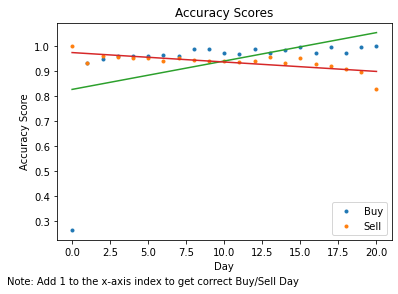

In [8]:
# Plot the Accuracy Scores
x = np.arange(21)
y = acc_score[1:22]
y2 = acc_score[22:]

# Fit with polyfit
b, m = polyfit(x, y, 1)
b2, m2 = polyfit(x, y2, 1)

# Add title and axis names
plt.title('Accuracy Scores')
plt.xlabel('Day')
plt.ylabel('Accuracy Score')

# Add a footnote below and to the left side of the chart
plt.figtext(0.01, -0.03,
            'Note: Add 1 to the x-axis index to get correct Buy/Sell Day',
            horizontalalignment='left')

plt.plot(x, y, '.', label="Buy")
plt.plot(x, y2, '.', label="Sell")
plt.plot(x, m*x+b, '-')
plt.plot(x, m2*x+b2, '-')
plt.legend()
plt.show()

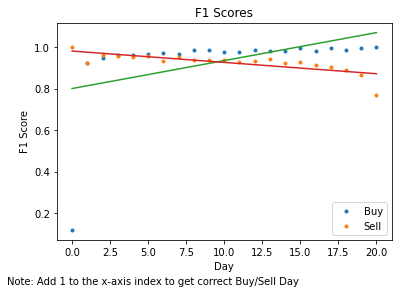

In [9]:
# Plot the F1 Scores
x = np.arange(21)
y = f1[1:22]
y2 = f1[22:]

# Fit with polyfit
b, m = polyfit(x, y, 1)
b2, m2 = polyfit(x, y2, 1)

# Add title and axis names
plt.title('F1 Scores')
plt.xlabel('Day')
plt.ylabel('F1 Score')

# Add a footnote below and to the left side of the chart
plt.figtext(0.01, -0.03,
            'Note: Add 1 to the x-axis index to get correct Buy/Sell Day',
            horizontalalignment='left')

plt.plot(x, y, '.', label="Buy")
plt.plot(x, y2, '.', label="Sell")
plt.plot(x, m*x+b, '-')
plt.plot(x, m2*x+b2, '-')
plt.legend()
plt.show()